In [1]:
# read j3 wrf ts files

import os
os.environ['PROJ_LIB'] = '/home/jlee/.conda/envs/mmc_sgp/share/proj'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from dateutil import parser
import datetime
import matplotlib.colors as mcolors

import mmctools
from mmctools.wrf.utils import Tower
from mmctools.helper_functions import calc_wind, model4D_calcQOIs
from mmctools.plotting import TaylorDiagram 

obs_dir = '/projects/mmc/jlee/sgp/sgp_obs/'
wrf_runs_dir = '/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/'
nb_dir = !pwd
plots_dir = nb_dir[0]+'/plots_03e'

# time step of wrf runs
d02_wrf_dt = 10
d03_wrf_dt = 2
d04_wrf_dt = 0.4

# tower location & domain number to analyze
# sim_dict = {'meso': ['c1.d02', d02_wrf_dt], 'les': ['c1.d04', d04_wrf_dt]}
# sim_dict = {'meso': ['c1.d02', d02_wrf_dt], 'les': ['c1.d03', d03_wrf_dt]}
# run nickname, tower name & domain, time step, spin up time in hour
sim_dict = {'meso': ['c1.d02', d02_wrf_dt, np.timedelta64(12, 'h')], 
            'les200m': ['c1.d03', d03_wrf_dt, np.timedelta64(2, 'h')], 
            'les40m': ['c1.d04', d04_wrf_dt, np.timedelta64(1, 'h')]}

# les averaging time, matching obs
# les_avg_time = '15Min'

# exclude les spin up time
# les_spinup = np.timedelta64(1, 'h')

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

# obs
# dlprofwind_ncs = obs_dir+'sgpdlprofwind4newsC1.c1/*.nc'
dlprofwstats_ncs = obs_dir+'sgpdlprofwstats4newsC1.c1/*.nc'

# dlprofwind = xr.open_mfdataset(dlprofwind_ncs)
dlprofwstats = xr.open_mfdataset(dlprofwstats_ncs)

# according to Rob Newsom, lidar data taken < 100 m need to be thrown out
toss_wp_data_below_height = 100

# vertical profile plot top height threshold
profile_hgt_thres = 2000

# plotting variables
dlprofwind_dict = {'ws': ['wind_speed', r'ws (m s$^{-1}$)'], 
                   'wd': ['wind_direction', 'wd (deg)']}
dlprofwstats_dict = {'w': ['w', r'w (m s$^{-1}$)']}

In [2]:
def get_wp_height_list(wp_ds):

    wp_height_list = list(wp_ds.height.where((wp_ds.height > toss_wp_data_below_height)).values)
    
    return [x for x in wp_height_list if str(x) != 'nan']

def read_tower_to_ds(tower, wrf_start, dt, lev): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=lev, height_var='ph', agl=True)

    ds['wspd'], ds['wdir'] = calc_wind(ds)
    
    # 10 minute average window to match lidar
    ds = model4D_calcQOIs(ds, mean_dim='datetime', data_type='ts', lowess_delta=10*60*dt)

    return ds

In [3]:
def plot_w_wvar(eval_date, obs, row):

    date_col = data_dir_df[eval_date]

    # start date & end date are the same because only looking at 24 hours of data
    obs_ds = obs.sel(time=slice(eval_date, eval_date))

    # for lidar...
    obs_height_list = get_wp_height_list(obs_ds)
    obs_ds = obs_ds.sel(height=obs_height_list)
    obs_ds_sel = obs_ds.where(obs_ds.snr > 0.008)

    # select more model heights than obs
    wrf_height_list = obs_height_list # +list(range(10, 101))[0::10]+list(range(350, 3000))[0::100]
    wrf_height_list.sort()

    wrf_dir = wrf_runs_dir+date_col[row]+'/'

    c1_meso_file_path = wrf_dir+'z_ts/z.'+sim_dict['meso'][0]
    meso_tower = Tower(c1_meso_file_path)

    c1_les200_file_path = wrf_dir+'z_ts/z.'+sim_dict['les200m'][0]
    les200_tower = Tower(c1_les200_file_path)

    c1_les40_file_path = wrf_dir+'z_ts/z.'+sim_dict['les40m'][0]
    les40_tower = Tower(c1_les40_file_path)

    # simulation start time
    wrf_start = date_col['wrf_start']

    wrf_meso_ds = read_tower_to_ds(meso_tower, wrf_start, sim_dict['meso'][1], wrf_height_list)
    wrf_les200_ds = read_tower_to_ds(les200_tower, wrf_start, sim_dict['les200m'][1], wrf_height_list)
    wrf_les40_ds = read_tower_to_ds(les40_tower, wrf_start, sim_dict['les40m'][1], wrf_height_list)

    meso_plot = wrf_meso_ds.sel(datetime=slice(
        wrf_les40_ds['datetime'].min().values+sim_dict['les40m'][2], obs_ds['time'].max().values),
                                      height=slice(wrf_meso_ds['height'].min().values, profile_hgt_thres)).squeeze()
    les200_plot = wrf_les200_ds.sel(datetime=slice(
        wrf_les40_ds['datetime'].min().values+sim_dict['les40m'][2], obs_ds['time'].max().values),
                                         height=slice(wrf_les200_ds['height'].min().values, profile_hgt_thres)
                                   ).squeeze()
    les40_plot = wrf_les40_ds.sel(datetime=slice(
        wrf_les40_ds['datetime'].min().values+sim_dict['les40m'][2], obs_ds['time'].max().values), 
                                        height=slice(wrf_les40_ds['height'].min().values, profile_hgt_thres)
                                 ).squeeze()

    obs_plot = obs_ds_sel.sel(time=slice(
        wrf_les40_ds['datetime'].min().values+sim_dict['les40m'][2], obs_ds['time'].max().values), 
                                        height=slice(obs_ds_sel['height'].min().values, profile_hgt_thres))
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))

    contour_min = np.min([obs_plot['w'].min(), meso_plot['w'].min(), les40_plot['w'].min()])
    contour_max = np.max([obs_plot['w'].max(), meso_plot['w'].max(), les40_plot['w'].max()])

    p0 = obs_plot['w'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[0], cmap='coolwarm')
    p1 = meso_plot['w'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[1], cmap='coolwarm')
    p2 = les40_plot['w'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[2], cmap='coolwarm')

    p0.colorbar.remove()
    p1.colorbar.remove()
    p2.colorbar.remove()

    ax[0].set_ylabel('height agl [m]')
    ax[1].set_ylabel('')
    ax[2].set_ylabel('')

    ax[0].set_xlabel('')
    ax[1].set_xlabel('date and UTC hour')
    ax[2].set_xlabel('')

    # ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

    # ax[0].set_xticklabels(np.unique(obs_plot['time'].dt.hour.values)[1:], rotation=0)

    # ticks_loc = ax[0].get_xticks().tolist()
    # ax[0].set_xticks(ax[0].get_xticks().tolist())
    # ax[0].set_xticklabels(np.unique(obs_plot['time'].dt.hour.values)[1:])

    ax[0].set_title('obs')
    ax[1].set_title('meso')
    ax[2].set_title('les')
    plt.suptitle(row+': vertical velocity')

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
    fig.colorbar(p2, cax=cbar_ax)

    # cb.remove()
    # plt.draw() #update plot
    # plt.tight_layout()

    plt.show()
    
    meso_plot_10avg = meso_plot.resample(datetime='10min').mean()
    les40_plot_10avg = les40_plot.resample(datetime='10min').mean()

    fig, ax = plt.subplots(1, 3, figsize=(12, 5))

    contour_min = np.min([obs_plot['w_variance'].min(), meso_plot_10avg['ww'].min(), les40_plot_10avg['ww'].min()])
    contour_max = np.max([obs_plot['w_variance'].max(), meso_plot_10avg['ww'].max(), les40_plot_10avg['ww'].max()])

    p0 = obs_plot['w_variance'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[0])
    p1 = meso_plot_10avg['ww'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[1])
    p2 = les40_plot_10avg['ww'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[2])

    p0.colorbar.remove()
    p1.colorbar.remove()
    p2.colorbar.remove()

    ax[0].set_ylabel('height agl [m]')
    ax[1].set_ylabel('')
    ax[2].set_ylabel('')

    ax[0].set_xlabel('')
    ax[1].set_xlabel('date and UTC hour')
    ax[2].set_xlabel('')

    ax[0].set_title('obs')
    ax[1].set_title('meso')
    ax[2].set_title('les')
    plt.suptitle(row+': 10-minute vertical velocity variance')

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
    fig.colorbar(p2, cax=cbar_ax)

    plt.show()

Calculating means... this may take a while.
calculating static means
calculating variances / covariances...
Calculating means... this may take a while.
calculating static means
calculating variances / covariances...
Calculating means... this may take a while.
calculating static means
calculating variances / covariances...


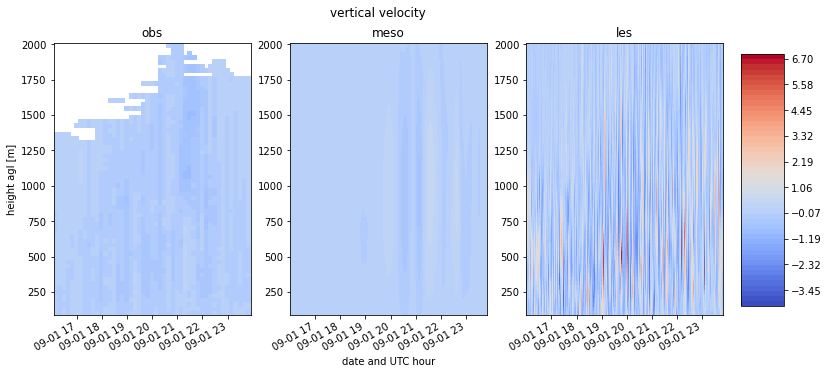

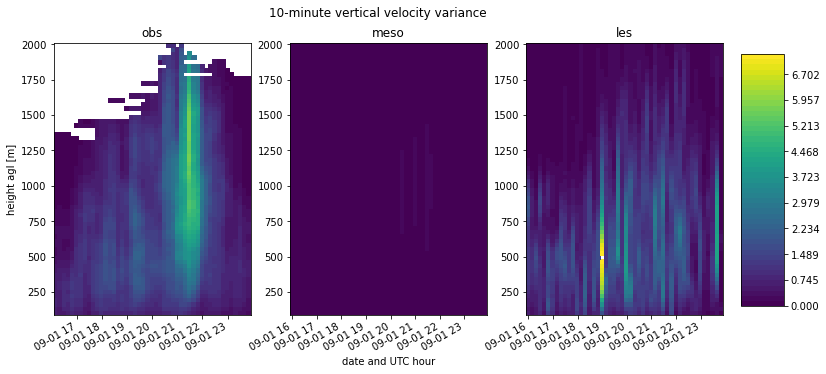

In [4]:
eval_date = '2018-09-01'
row = 'mynn'

plot_w_wvar(eval_date, dlprofwstats, row)

Calculating means... this may take a while.
calculating static means
calculating variances / covariances...
Calculating means... this may take a while.
calculating static means
calculating variances / covariances...
Calculating means... this may take a while.
calculating static means
calculating variances / covariances...


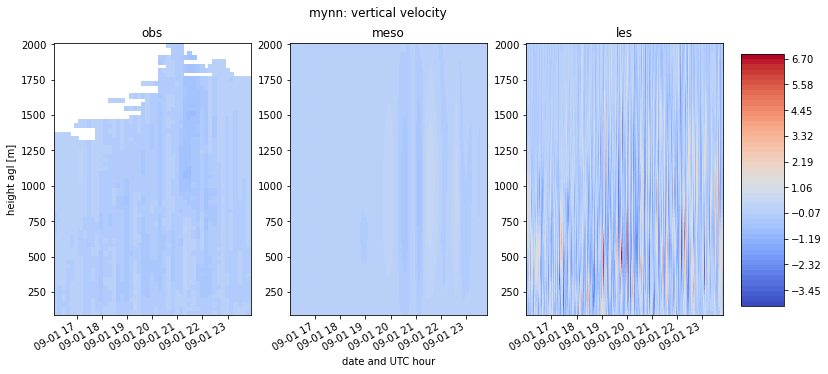

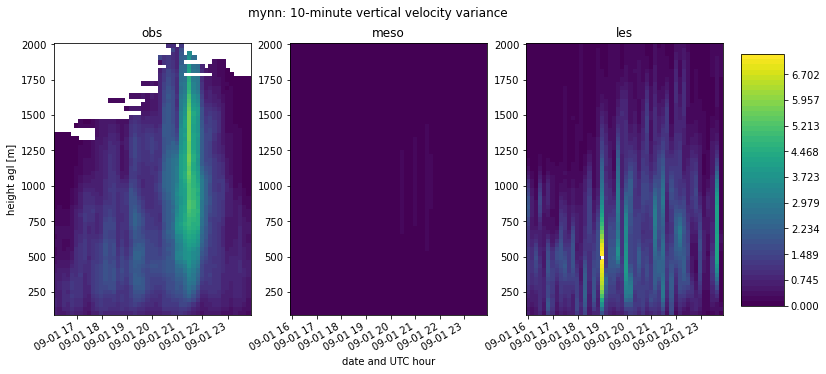

Calculating means... this may take a while.
calculating static means
calculating variances / covariances...
Calculating means... this may take a while.
calculating static means
calculating variances / covariances...
Calculating means... this may take a while.
calculating static means
calculating variances / covariances...


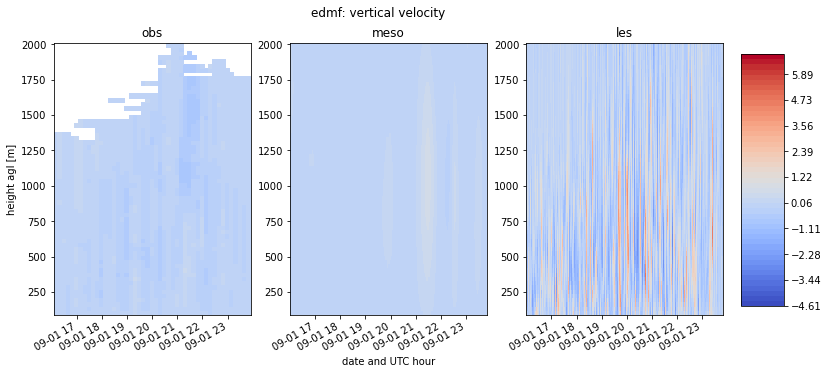

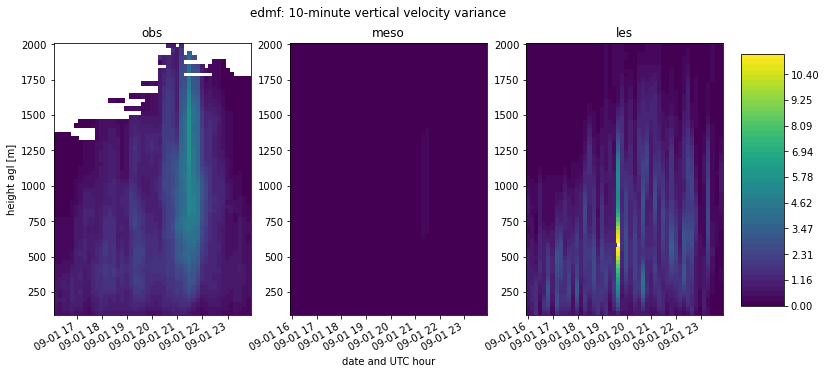

Calculating means... this may take a while.
calculating static means
calculating variances / covariances...
Calculating means... this may take a while.
calculating static means
calculating variances / covariances...
Calculating means... this may take a while.
calculating static means
calculating variances / covariances...


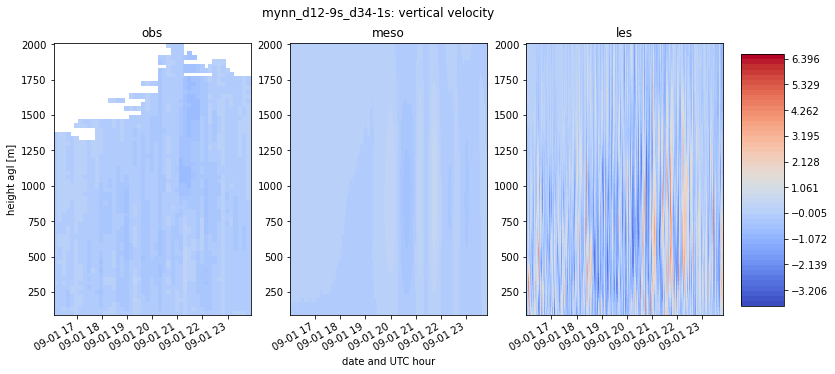

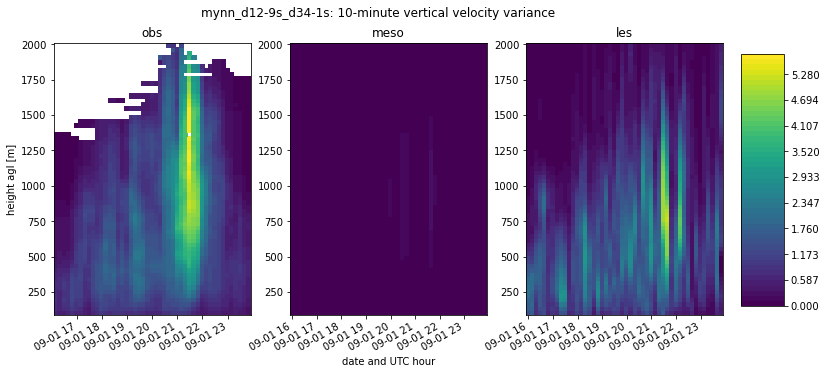

Calculating means... this may take a while.
calculating static means
calculating variances / covariances...
Calculating means... this may take a while.
calculating static means
calculating variances / covariances...
Calculating means... this may take a while.
calculating static means
calculating variances / covariances...


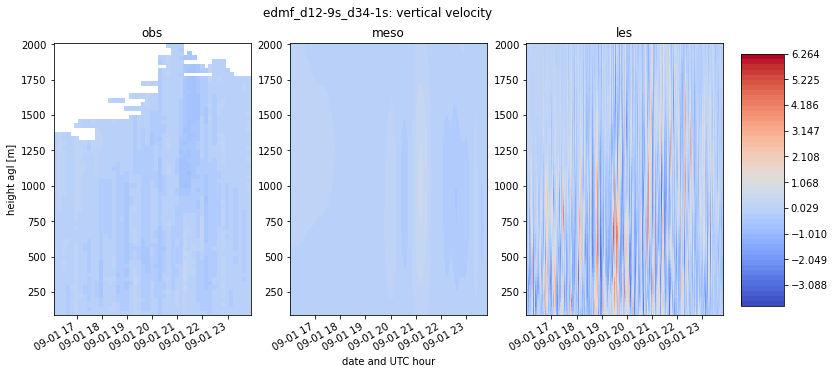

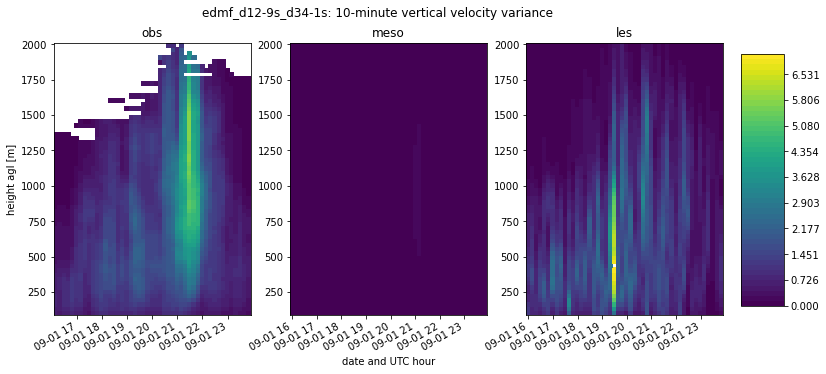

In [7]:
for row in ['mynn', 'edmf', 'mynn_d12-9s_d34-1s', 'edmf_d12-9s_d34-1s']: 
    plot_w_wvar(eval_date, dlprofwstats, row)

In [4]:
eval_date = '2018-09-01'
obs = dlprofwstats
sim1 = 'mynn'
sim2 = 'mynn_d12-9s_d34-1s'

date_col = data_dir_df[eval_date]

# start date & end date are the same because only looking at 24 hours of data
obs_ds = obs.sel(time=slice(eval_date, eval_date))

# for lidar...
obs_height_list = get_wp_height_list(obs_ds)
obs_ds = obs_ds.sel(height=obs_height_list)
obs_ds_sel = obs_ds.where(obs_ds.snr > 0.008)

# select more model heights than obs
wrf_height_list = obs_height_list # +list(range(10, 101))[0::10]+list(range(350, 3000))[0::100]
wrf_height_list.sort()

def get_meso_les40_10avg(sim):

    wrf_dir = wrf_runs_dir+date_col[sim]+'/'

    c1_meso_file_path = wrf_dir+'z_ts/z.'+sim_dict['meso'][0]
    meso_tower = Tower(c1_meso_file_path)

    c1_les40_file_path = wrf_dir+'z_ts/z.'+sim_dict['les40m'][0]
    les40_tower = Tower(c1_les40_file_path)

    # simulation start time
    wrf_start = date_col['wrf_start']

    wrf_meso_ds = read_tower_to_ds(meso_tower, wrf_start, sim_dict['meso'][1], wrf_height_list)
    wrf_les40_ds = read_tower_to_ds(les40_tower, wrf_start, sim_dict['les40m'][1], wrf_height_list)

    meso_plot = wrf_meso_ds.sel(datetime=slice(
        wrf_les40_ds['datetime'].min().values+sim_dict['les40m'][2], obs_ds['time'].max().values),
                                      height=slice(wrf_meso_ds['height'].min().values, profile_hgt_thres)).squeeze()

    les40_plot = wrf_les40_ds.sel(datetime=slice(
        wrf_les40_ds['datetime'].min().values+sim_dict['les40m'][2], obs_ds['time'].max().values), 
                                        height=slice(wrf_les40_ds['height'].min().values, profile_hgt_thres)
                                 ).squeeze()

    meso_plot_10avg = meso_plot.resample(datetime='10min').mean()
    les40_plot_10avg = les40_plot.resample(datetime='10min').mean()

    return meso_plot_10avg, les40_plot_10avg

meso_sim1_10avg, les40_sim1_10avg = get_meso_les40_10avg(sim1)

obs_plot = obs_ds_sel.sel(time=slice(les40_sim1_10avg['datetime'].min().values, obs_ds['time'].max().values), 
                                    height=slice(obs_ds_sel['height'].min().values, profile_hgt_thres))

meso_sim2_10avg, les40_sim2_10avg = get_meso_les40_10avg(sim2)

Calculating means... this may take a while.
calculating static means
calculating variances / covariances...
Calculating means... this may take a while.
calculating static means
calculating variances / covariances...
Calculating means... this may take a while.
calculating static means
calculating variances / covariances...
Calculating means... this may take a while.
calculating static means
calculating variances / covariances...


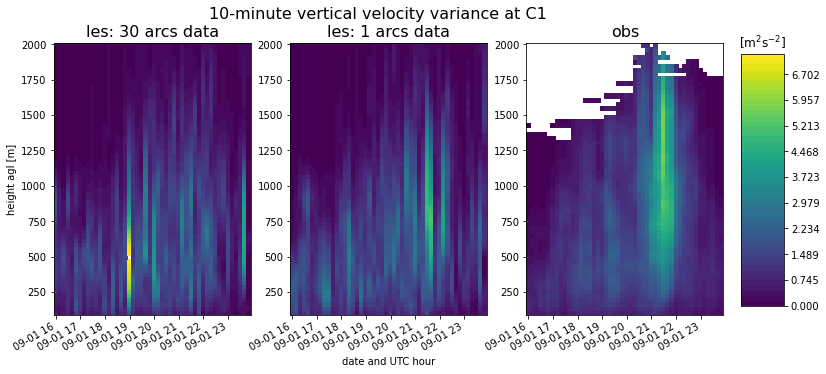

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

contour_min = np.min([obs_plot['w_variance'].min(), les40_sim1_10avg['ww'].min(), les40_sim2_10avg['ww'].min()])
contour_max = np.max([obs_plot['w_variance'].max(), les40_sim1_10avg['ww'].max(), les40_sim2_10avg['ww'].max()])

p0 = les40_sim1_10avg['ww'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[0])
p1 = les40_sim2_10avg['ww'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[1])
p2 = obs_plot['w_variance'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[2])

p0.colorbar.remove()
p1.colorbar.remove()
p2.colorbar.remove()

ax[0].set_ylabel('height agl [m]')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_xlabel('')
ax[1].set_xlabel('date and UTC hour')
ax[2].set_xlabel('')

fs = 16

ax[0].set_title('les: 30 arcs data', fontsize=fs)
ax[1].set_title('les: 1 arcs data', fontsize=fs)
ax[2].set_title('obs', fontsize=fs)
plt.suptitle('10-minute vertical velocity variance at C1', fontsize=fs)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
clb = fig.colorbar(p2, cax=cbar_ax)
clb.ax.set_title(r'[m$^{2}$s$^{-2}$]')
# clb.ax.set_title(var.units, pad=12)

plt.show()

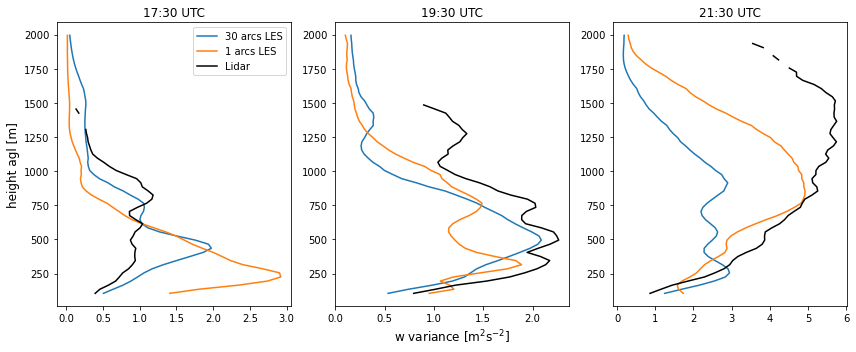

In [85]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

timestep = obs_plot['time'][9:-10:12]

for i in range(3):

    ax[i].plot(les40_sim1_10avg.sel(datetime=timestep[i])['ww'], les40_sim1_10avg['height'], label='30 arcs LES')
    ax[i].plot(les40_sim2_10avg.sel(datetime=timestep[i])['ww'], les40_sim2_10avg['height'], label='1 arcs LES')
    ax[i].plot(obs_plot.sel(time=timestep[i])['w_variance'], obs_plot['height'], label='Lidar', c='k')
    t = pd.Timestamp(timestep[i].values)
    ax[i].set_title(str(t.hour)+':'+str(t.minute)+' UTC')
    
ax[0].legend()
ax[0].set_ylabel('height agl [m]', fontsize=12)
ax[1].set_xlabel(r'w variance [m$^{2}$s$^{-2}$]', fontsize=12)

plt.tight_layout()
plt.show()

In [71]:
pd.Timestamp(timestep[i].values).hour

21

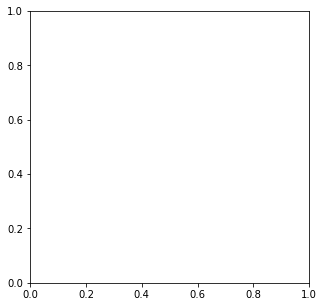

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))

# ax.plot(les40_sim1_10avg.sel(datetime=time_i))

In [6]:
les40_sim1_10avg

<xarray.Dataset>
Dimensions:    (datetime: 48, height: 64)
Coordinates:
  * datetime   (datetime) datetime64[ns] 2018-09-01T16:00:00 ... 2018-09-01T2...
  * height     (height) float64 105.0 135.0 165.0 ... 1.965e+03 1.995e+03
    station    <U4 'z.c1'
Data variables:
    w          (datetime, height) float64 -0.2663 -0.2719 ... -0.5244 -0.5193
    v          (datetime, height) float64 8.714 8.576 8.532 ... 5.99 6.064 6.139
    u          (datetime, height) float64 2.185 2.317 2.546 ... -0.2561 -0.5607
    theta      (datetime, height) float64 304.8 304.8 304.8 ... 312.8 313.1
    pr         (datetime, height) float64 9.65e+04 9.619e+04 ... 7.804e+04
    qv         (datetime, height) float64 0.01503 0.01502 ... 0.006192 0.005901
    i          (datetime) float64 115.0 115.0 115.0 115.0 ... 115.0 115.0 115.0
    j          (datetime) float64 270.0 270.0 270.0 270.0 ... 270.0 270.0 270.0
    lat        (datetime) float64 36.61 36.61 36.61 36.61 ... 36.61 36.61 36.61
    lon        (datetime) float64 -97.49 -97.49 -97.49 ... -97.49 -97.49 -97.49
    zsurface   (datetime) float64 314.0 314.0 314.0 314.0 ... 314.0 314.0 314.0
    t2         (datetime) float64 -999.0 992.2 1.04e+04 ... -999.0 -999.0 -999.0
    q2         (datetime) float64 -999.0 992.2 1.04e+04 ... -999.0 -999.0 -999.0
    u10        (datetime) float64 -999.0 984.6 1.04e+04 ... -999.0 -999.0 -999.0
    v10        (datetime) float64 -999.0 984.6 1.04e+04 ... -999.0 -999.0 -999.0
    psfc       (datetime) float64 0.7285 0.733 0.7357 ... 0.5923 0.5691 0.5577
    lwd        (datetime) float64 44.12 42.45 40.85 39.3 ... 74.73 76.74 77.75
    swd        (datetime) float64 702.5 726.5 747.6 766.9 ... 211.2 176.9 161.8
    hfx        (datetime) float64 661.9 671.6 670.7 660.9 ... 545.8 500.9 479.0
    lfx        (datetime) float64 227.9 231.6 240.9 256.1 ... 66.47 61.08 58.49
    tsk        (datetime) float64 715.3 739.0 761.0 781.8 ... 211.2 177.0 161.8
    slttop     (datetime) float64 842.0 849.3 855.7 861.7 ... 546.1 501.2 479.1
    rainc      (datetime) float64 690.7 710.6 729.2 746.5 ... 217.7 182.6 165.2
    rainnc     (datetime) float64 566.1 568.6 567.8 567.2 ... 543.9 500.1 476.1
    clw        (datetime) float64 284.8 291.7 300.2 308.1 ... 73.45 66.88 63.34
    qfx        (datetime) float64 715.9 738.9 760.5 780.5 ... 218.0 182.8 165.4
    ust        (datetime) float64 828.0 834.5 840.4 845.8 ... 544.9 500.9 476.7
    wspd       (datetime, height) float64 9.042 8.945 8.967 ... 5.99 6.07 6.164
    wdir       (datetime, height) float64 194.2 195.3 196.8 ... 177.6 174.8
    uMean      (datetime, height) float64 -1.714 -1.659 -1.603 ... 0.1503 0.0456
    vMean      (datetime, height) float64 8.88 8.929 8.953 ... 6.988 6.928 6.868
    wMean      (datetime, height) float64 -0.04725 -0.05921 ... -0.06981
    thetaMean  (datetime, height) float64 308.4 308.4 308.4 ... 312.4 312.6
    UMean      (datetime, height) float64 9.615 9.654 9.672 ... 7.044 6.987
    UdirMean   (datetime, height) float64 170.8 171.2 171.5 ... 181.1 180.2
    uu         (datetime, height) float64 16.1 16.74 18.15 ... 0.1651 0.3676
    vv         (datetime, height) float64 0.6531 0.741 0.8214 ... 0.7467 0.5325
    ww         (datetime, height) float64 0.6272 0.595 0.608 ... 0.205 0.2021
    uv         (datetime, height) float64 -0.9946 -1.785 ... 0.3512 0.4424
    uw         (datetime, height) float64 -0.7277 -0.7465 ... 0.184 0.2725
    vw         (datetime, height) float64 -0.111 -0.06057 ... 0.3912 0.328
    wth        (datetime, height) float64 0.924 0.8969 0.692 ... -0.1736 -0.2215
    UU         (datetime, height) float64 0.8062 0.9407 0.9395 ... 0.9501 0.6762
    Uw         (datetime, height) float64 0.02786 0.0462 ... 0.4413 0.3697
    TKE        (datetime, height) float64 0.5207 0.5581 0.5597 ... 0.5374 0.4686

In [8]:
obs_plot['w_variance']

<xarray.DataArray 'w_variance' (time: 48, height: 64)>
dask.array<getitem, shape=(48, 64), dtype=float32, chunksize=(48, 64), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-09-01T16:00:00 ... 2018-09-01T23:50:00
  * height   (height) float32 105.0 135.0 165.0 ... 1.965e+03 1.995e+03
Attributes:
    long_name:  Noise corrected vertical velocity variance
    units:      m^2 s^-2

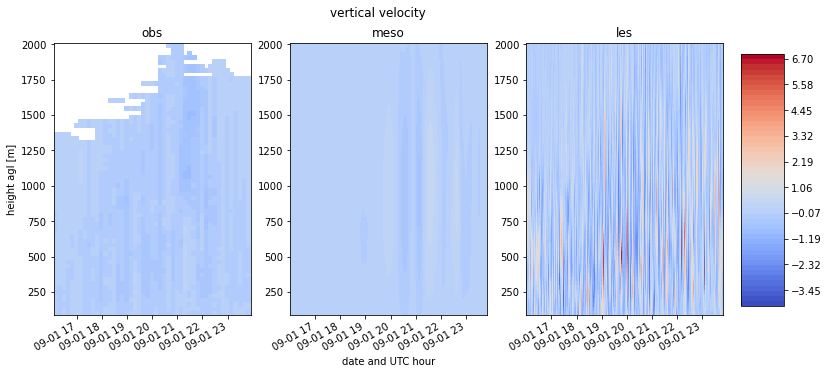

In [238]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

contour_min = np.min([obs_plot['w'].min(), meso_plot['w'].min(), les40_plot['w'].min()])
contour_max = np.max([obs_plot['w'].max(), meso_plot['w'].max(), les40_plot['w'].max()])

p0 = obs_plot['w'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[0], cmap='coolwarm')
p1 = meso_plot['w'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[1], cmap='coolwarm')
p2 = les40_plot['w'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[2], cmap='coolwarm')

p0.colorbar.remove()
p1.colorbar.remove()
p2.colorbar.remove()

ax[0].set_ylabel('height agl [m]')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_xlabel('')
ax[1].set_xlabel('date and UTC hour')
ax[2].set_xlabel('')

# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

# ax[0].set_xticklabels(np.unique(obs_plot['time'].dt.hour.values)[1:], rotation=0)

# ticks_loc = ax[0].get_xticks().tolist()
# ax[0].set_xticks(ax[0].get_xticks().tolist())
# ax[0].set_xticklabels(np.unique(obs_plot['time'].dt.hour.values)[1:])

ax[0].set_title('obs')
ax[1].set_title('meso')
ax[2].set_title('les')
plt.suptitle('vertical velocity')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
fig.colorbar(p2, cax=cbar_ax)

# cb.remove()
# plt.draw() #update plot
# plt.tight_layout()

plt.show()

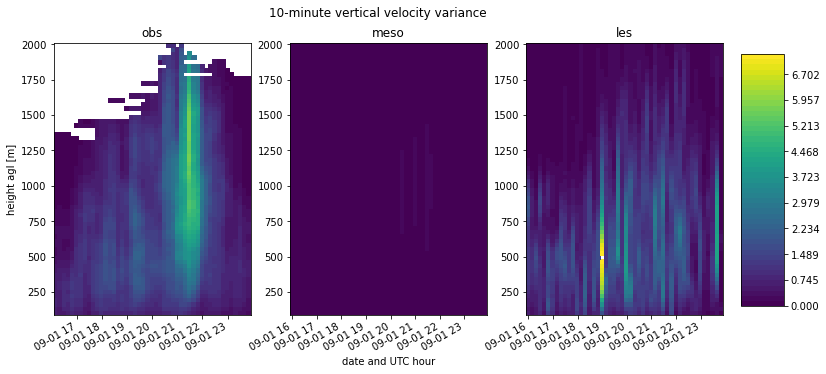

In [239]:
meso_plot_10avg = meso_plot.resample(datetime='10min').mean()
les40_plot_10avg = les40_plot.resample(datetime='10min').mean()

fig, ax = plt.subplots(1, 3, figsize=(12, 5))

contour_min = np.min([obs_plot['w_variance'].min(), meso_plot_10avg['ww'].min(), les40_plot_10avg['ww'].min()])
contour_max = np.max([obs_plot['w_variance'].max(), meso_plot_10avg['ww'].max(), les40_plot_10avg['ww'].max()])

p0 = obs_plot['w_variance'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[0])
p1 = meso_plot_10avg['ww'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[1])
p2 = les40_plot_10avg['ww'].T.plot(levels=np.linspace(contour_min ,contour_max), ax=ax[2])

p0.colorbar.remove()
p1.colorbar.remove()
p2.colorbar.remove()

ax[0].set_ylabel('height agl [m]')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_xlabel('')
ax[1].set_xlabel('date and UTC hour')
ax[2].set_xlabel('')

ax[0].set_title('obs')
ax[1].set_title('meso')
ax[2].set_title('les')
plt.suptitle('10-minute vertical velocity variance')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
fig.colorbar(p2, cax=cbar_ax)

plt.show()

In [233]:
meso_plot

<xarray.Dataset>
Dimensions:    (datetime: 2820, height: 64)
Coordinates:
  * datetime   (datetime) datetime64[ns] 2018-09-01T16:00:10 ... 2018-09-01T2...
  * height     (height) float64 105.0 135.0 165.0 ... 1.965e+03 1.995e+03
    station    <U4 'z.c1'
Data variables:
    theta      (datetime, height) float64 305.0 304.9 304.9 ... 312.1 312.4
    pr         (datetime, height) float64 9.658e+04 9.627e+04 ... 7.811e+04
    w          (datetime, height) float64 -0.01498 -0.01391 ... -0.02054
    u          (datetime, height) float64 2.071 2.165 2.254 ... -0.3146 -0.307
    qv         (datetime, height) float64 0.01517 0.01514 ... 0.006944 0.006562
    v          (datetime, height) float64 7.31 7.493 7.65 ... 7.139 7.025 6.912
    i          int64 122
    j          int64 126
    lat        float64 36.62
    lon        float64 -97.49
    zsurface   float64 306.8
    t2         (datetime) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0 -999.0
    q2         (datetime) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0 -999.0
    u10        (datetime) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0 -999.0
    v10        (datetime) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0 -999.0
    psfc       (datetime) float64 0.7223 0.7223 0.7223 ... 0.5563 0.5563 0.5563
    lwd        (datetime) float64 44.8 44.77 44.74 44.71 ... 77.85 77.88 77.92
    swd        (datetime) float64 689.4 689.4 689.4 689.4 ... 161.4 161.4 161.4
    hfx        (datetime) float64 622.6 622.6 622.6 622.6 ... 478.7 478.7 478.7
    lfx        (datetime) float64 247.6 247.6 247.6 247.6 ... 58.15 58.15 58.15
    tsk        (datetime) float64 705.3 705.3 705.3 705.3 ... 161.4 161.4 161.4
    slttop     (datetime) float64 839.3 839.3 839.3 839.3 ... 478.9 478.9 478.9
    rainc      (datetime) float64 675.3 675.6 676.0 676.4 ... 165.3 164.7 164.1
    rainnc     (datetime) float64 547.6 548.2 548.7 549.2 ... 478.4 477.6 476.7
    clw        (datetime) float64 288.4 288.2 288.0 287.8 ... 62.11 61.99 61.87
    qfx        (datetime) float64 699.6 700.0 700.4 700.8 ... 165.4 164.9 164.3
    ust        (datetime) float64 824.4 824.5 824.6 824.7 ... 479.0 478.1 477.3
    wspd       (datetime, height) float64 7.597 7.8 7.975 ... 7.146 7.032 6.918
    wdir       (datetime, height) float64 195.8 196.1 196.4 ... 177.4 177.5
    uMean      (height) float64 -0.1551 -0.03489 0.1098 ... 4.394 4.342 4.289
    vMean      (height) float64 10.26 10.78 11.25 11.68 ... 7.032 6.972 6.912
    wMean      (height) float64 -0.01895 -0.01893 -0.01887 ... 0.01215 0.01248
    thetaMean  (height) float64 306.5 306.6 306.6 306.7 ... 313.0 313.1 313.2
    UMean      (height) float64 10.44 10.97 11.44 11.88 ... 8.99 8.9 8.812 8.724
    UdirMean   (height) float64 179.2 179.9 180.6 181.3 ... 210.2 210.1 210.0
    uu         (datetime, height) float64 4.956 4.839 4.598 ... 21.68 21.12
    vv         (datetime, height) float64 8.691 10.81 ... 0.002814 6.731e-07
    ww         (datetime, height) float64 1.577e-05 2.529e-05 ... 0.00109
    uv         (datetime, height) float64 -6.563 -7.232 ... -0.247 0.003771
    uw         (datetime, height) float64 0.008839 0.01106 ... 0.1685 0.1518
    vw         (datetime, height) float64 -0.01171 -0.01653 ... 2.709e-05
    wth        (datetime, height) float64 -0.00601 -0.008195 ... 0.03589 0.02858
    UU         (datetime, height) float64 8.087 10.04 12.04 ... 3.077 3.165 3.26
    Uw         (datetime, height) float64 -0.01129 -0.01593 ... 0.06437 0.05961
    TKE        (datetime, height) float64 1.422 1.584 1.735 ... 0.8897 0.9029
Attributes:
    MEAN_OPT:  static

In [235]:
meso_plot.resample(datetime='10min').mean()

<xarray.Dataset>
Dimensions:    (datetime: 48, height: 64)
Coordinates:
  * datetime   (datetime) datetime64[ns] 2018-09-01T16:00:00 ... 2018-09-01T2...
  * height     (height) float64 105.0 135.0 165.0 ... 1.965e+03 1.995e+03
    station    <U4 'z.c1'
Data variables:
    theta      (datetime, height) float64 305.2 305.1 305.1 ... 312.1 312.4
    pr         (datetime, height) float64 9.658e+04 9.627e+04 ... 7.811e+04
    w          (datetime, height) float64 -0.01505 -0.01373 ... -0.02054
    u          (datetime, height) float64 2.017 2.106 2.192 ... -0.3146 -0.307
    qv         (datetime, height) float64 0.01514 0.01511 ... 0.006944 0.006562
    v          (datetime, height) float64 7.245 7.424 7.577 ... 7.025 6.912
    i          (datetime) float64 122.0 122.0 122.0 122.0 ... 122.0 122.0 122.0
    j          (datetime) float64 126.0 126.0 126.0 126.0 ... 126.0 126.0 126.0
    lat        (datetime) float64 36.62 36.62 36.62 36.62 ... 36.62 36.62 36.62
    lon        (datetime) float64 -97.49 -97.49 -97.49 ... -97.49 -97.49 -97.49
    zsurface   (datetime) float64 306.8 306.8 306.8 306.8 ... 306.8 306.8 306.8
    t2         (datetime) float64 -999.0 6.031e+03 1.04e+04 ... -999.0 -999.0
    q2         (datetime) float64 -999.0 6.031e+03 1.04e+04 ... -999.0 -999.0
    u10        (datetime) float64 -999.0 6.031e+03 1.04e+04 ... -999.0 -999.0
    v10        (datetime) float64 -999.0 6.031e+03 1.04e+04 ... -999.0 -999.0
    psfc       (datetime) float64 0.7266 0.7308 0.733 ... 0.5926 0.5684 0.5563
    lwd        (datetime) float64 43.98 42.33 40.73 39.19 ... 74.89 76.9 77.92
    swd        (datetime) float64 700.6 723.9 744.4 762.1 ... 211.5 177.1 161.4
    hfx        (datetime) float64 658.3 671.6 664.7 639.4 ... 547.4 501.7 478.7
    lfx        (datetime) float64 228.6 229.3 242.5 268.0 ... 66.21 60.83 58.15
    tsk        (datetime) float64 713.7 736.8 758.6 779.5 ... 211.6 177.1 161.4
    slttop     (datetime) float64 841.9 848.8 855.2 860.9 ... 547.7 501.9 478.9
    rainc      (datetime) float64 685.6 705.1 723.3 740.4 ... 216.8 181.7 164.1
    rainnc     (datetime) float64 557.1 557.8 552.7 552.0 ... 545.1 501.2 476.7
    clw        (datetime) float64 286.5 294.4 306.0 314.0 ... 71.77 65.39 61.87
    qfx        (datetime) float64 711.0 733.7 755.1 775.2 ... 217.1 182.0 164.3
    ust        (datetime) float64 827.7 834.2 840.1 845.3 ... 546.1 502.0 477.3
    wspd       (datetime, height) float64 7.521 7.717 7.888 ... 7.032 6.918
    wdir       (datetime, height) float64 195.6 195.8 196.1 ... 177.4 177.5
    uMean      (datetime, height) float64 -0.1551 -0.03489 ... 4.342 4.289
    vMean      (datetime, height) float64 10.26 10.78 11.25 ... 6.972 6.912
    wMean      (datetime, height) float64 -0.01895 -0.01893 ... 0.01215 0.01248
    thetaMean  (datetime, height) float64 306.5 306.6 306.6 ... 313.1 313.2
    UMean      (datetime, height) float64 10.44 10.97 11.44 ... 8.9 8.812 8.724
    UdirMean   (datetime, height) float64 179.2 179.9 180.6 ... 210.1 210.0
    uu         (datetime, height) float64 4.72 4.587 4.338 ... 22.25 21.68 21.12
    vv         (datetime, height) float64 9.076 11.27 ... 0.002814 6.731e-07
    ww         (datetime, height) float64 1.726e-05 3.029e-05 ... 0.00109
    uv         (datetime, height) float64 -6.542 -7.187 ... -0.247 0.003771
    uw         (datetime, height) float64 0.008466 0.01117 ... 0.1685 0.1518
    vw         (datetime, height) float64 -0.01173 -0.01747 ... 2.709e-05
    wth        (datetime, height) float64 -0.005265 -0.007661 ... 0.02858
    UU         (datetime, height) float64 8.53 10.57 12.65 ... 3.077 3.165 3.26
    Uw         (datetime, height) float64 -0.01137 -0.01692 ... 0.06437 0.05961
    TKE        (datetime, height) float64 1.46 1.625 1.778 ... 0.8897 0.9029

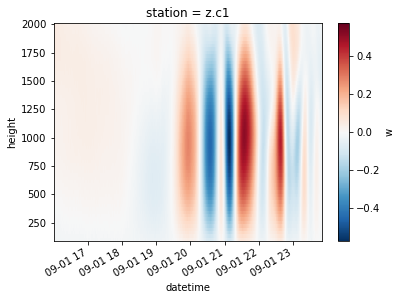

In [38]:
wrf_meso_ds_cut['w'].T.plot()

In [50]:
meso_plot = wrf_meso_ds.sel(datetime=slice(
    wrf_les40_ds['datetime'].min().values+sim_dict['les40m'][2], obs_ds['time'].max().values),
                                  height=slice(wrf_meso_ds['height'].min().values, profile_hgt_thres)).squeeze()
les200_plot = wrf_les200_ds.sel(datetime=slice(
    wrf_les40_ds['datetime'].min().values+sim_dict['les40m'][2], obs_ds['time'].max().values),
                                     height=slice(wrf_les200_ds['height'].min().values, profile_hgt_thres)).squeeze()
les40_plot = wrf_les40_ds.sel(datetime=slice(
    wrf_les40_ds['datetime'].min().values+sim_dict['les40m'][2], obs_ds['time'].max().values), 
                                    height=slice(wrf_les40_ds['height'].min().values, profile_hgt_thres)).squeeze()

obs_plot = obs_ds_sel.sel(time=slice(
    wrf_les40_ds['datetime'].min().values+sim_dict['les40m'][2], obs_ds['time'].max().values), 
                                    height=slice(obs_ds_sel['height'].min().values, profile_hgt_thres))

In [49]:
meso_plot.squeeze()

<xarray.Dataset>
Dimensions:    (datetime: 2820, height: 64)
Coordinates:
  * datetime   (datetime) datetime64[ns] 2018-09-01T16:00:10 ... 2018-09-01T2...
  * height     (height) float64 105.0 135.0 165.0 ... 1.965e+03 1.995e+03
    station    <U4 'z.c1'
Data variables:
    theta      (datetime, height) float64 305.0 304.9 304.9 ... 312.1 312.4
    pr         (datetime, height) float64 9.658e+04 9.627e+04 ... 7.811e+04
    w          (datetime, height) float64 -0.01498 -0.01391 ... -0.02054
    u          (datetime, height) float64 2.071 2.165 2.254 ... -0.3146 -0.307
    qv         (datetime, height) float64 0.01517 0.01514 ... 0.006944 0.006562
    v          (datetime, height) float64 7.31 7.493 7.65 ... 7.139 7.025 6.912
    i          int64 122
    j          int64 126
    lat        float64 36.62
    lon        float64 -97.49
    zsurface   float64 306.8
    t2         (datetime) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0 -999.0
    q2         (datetime) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0 -999.0
    u10        (datetime) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0 -999.0
    v10        (datetime) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0 -999.0
    psfc       (datetime) float64 0.7223 0.7223 0.7223 ... 0.5563 0.5563 0.5563
    lwd        (datetime) float64 44.8 44.77 44.74 44.71 ... 77.85 77.88 77.92
    swd        (datetime) float64 689.4 689.4 689.4 689.4 ... 161.4 161.4 161.4
    hfx        (datetime) float64 622.6 622.6 622.6 622.6 ... 478.7 478.7 478.7
    lfx        (datetime) float64 247.6 247.6 247.6 247.6 ... 58.15 58.15 58.15
    tsk        (datetime) float64 705.3 705.3 705.3 705.3 ... 161.4 161.4 161.4
    slttop     (datetime) float64 839.3 839.3 839.3 839.3 ... 478.9 478.9 478.9
    rainc      (datetime) float64 675.3 675.6 676.0 676.4 ... 165.3 164.7 164.1
    rainnc     (datetime) float64 547.6 548.2 548.7 549.2 ... 478.4 477.6 476.7
    clw        (datetime) float64 288.4 288.2 288.0 287.8 ... 62.11 61.99 61.87
    qfx        (datetime) float64 699.6 700.0 700.4 700.8 ... 165.4 164.9 164.3
    ust        (datetime) float64 824.4 824.5 824.6 824.7 ... 479.0 478.1 477.3
    wspd       (datetime, height) float64 7.597 7.8 7.975 ... 7.146 7.032 6.918
    wdir       (datetime, height) float64 195.8 196.1 196.4 ... 177.4 177.5
    uMean      (height) float64 -0.1551 -0.03489 0.1098 ... 4.394 4.342 4.289
    vMean      (height) float64 10.26 10.78 11.25 11.68 ... 7.032 6.972 6.912
    wMean      (height) float64 -0.01895 -0.01893 -0.01887 ... 0.01215 0.01248
    thetaMean  (height) float64 306.5 306.6 306.6 306.7 ... 313.0 313.1 313.2
    UMean      (height) float64 10.44 10.97 11.44 11.88 ... 8.99 8.9 8.812 8.724
    UdirMean   (height) float64 179.2 179.9 180.6 181.3 ... 210.2 210.1 210.0
    uu         (datetime, height) float64 4.956 4.839 4.598 ... 21.68 21.12
    vv         (datetime, height) float64 8.691 10.81 ... 0.002814 6.731e-07
    ww         (datetime, height) float64 1.577e-05 2.529e-05 ... 0.00109
    uv         (datetime, height) float64 -6.563 -7.232 ... -0.247 0.003771
    uw         (datetime, height) float64 0.008839 0.01106 ... 0.1685 0.1518
    vw         (datetime, height) float64 -0.01171 -0.01653 ... 2.709e-05
    wth        (datetime, height) float64 -0.00601 -0.008195 ... 0.03589 0.02858
    UU         (datetime, height) float64 8.087 10.04 12.04 ... 3.077 3.165 3.26
    Uw         (datetime, height) float64 -0.01129 -0.01593 ... 0.06437 0.05961
    TKE        (datetime, height) float64 1.422 1.584 1.735 ... 0.8897 0.9029
Attributes:
    MEAN_OPT:  static

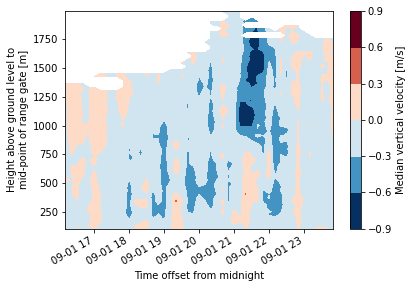

In [140]:
obs_plot['w'].T.plot.contourf()

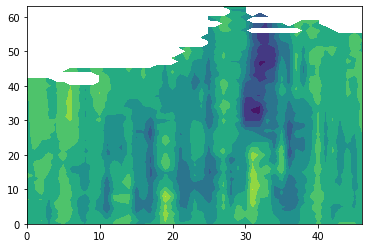

In [134]:
plt.contourf(obs_plot['w'].T)
plt.show()

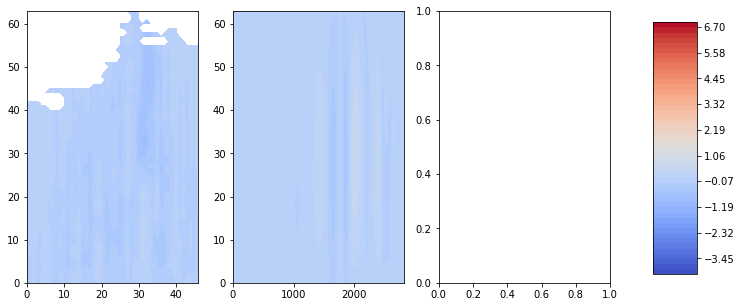

In [139]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

contour_min = np.min([obs_plot['w'].min(), meso_plot['w'].min(), les40_plot['w'].min()])
contour_max = np.max([obs_plot['w'].max(), meso_plot['w'].max(), les40_plot['w'].max()])

im = ax[0].contourf(obs_plot['w'].T, levels=np.linspace(contour_min ,contour_max), cmap='coolwarm')
ax[1].contourf(meso_plot['w'].T, levels=np.linspace(contour_min ,contour_max), cmap='coolwarm')
# ax[2].contourf(les40_plot['w'].T, levels=np.linspace(contour_min ,contour_max), cmap='coolwarm')

# ax[1].set_xticklabels(obs_plot['time'].values.min(), obs_plot['time'].values.max())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

contour_min = np.min([obs_plot['w'].min(), meso_plot['w'].min(), les40_plot['w'].min()])
contour_max = np.max([obs_plot['w'].max(), meso_plot['w'].max(), les40_plot['w'].max()])

im = ax[0].contourf(obs_plot['w'].T, levels=np.linspace(contour_min ,contour_max), cmap='coolwarm')
ax[1].contourf(meso_plot['w'].T, levels=np.linspace(contour_min ,contour_max), cmap='coolwarm')
ax[2].contourf(les40_plot['w'].T, levels=np.linspace(contour_min ,contour_max), cmap='coolwarm')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# plt.legend()

In [31]:
wrf_les40_ds_cut

<xarray.Dataset>
Dimensions:    (datetime: 70500, height: 130, station: 1)
Coordinates:
  * datetime   (datetime) datetime64[ns] 2018-09-01T16:00:00.400000 ... 2018-...
  * height     (height) float64 105.0 135.0 165.0 ... 3.945e+03 3.975e+03
  * station    (station) <U4 'z.c1'
Data variables:
    w          (datetime, height, station) float64 -1.194 -1.48 ... -0.07621
    v          (datetime, height, station) float64 10.36 9.723 ... 6.069 6.021
    u          (datetime, height, station) float64 2.783 2.852 ... -0.1225
    theta      (datetime, height, station) float64 304.8 304.7 ... 319.3 319.3
    pr         (datetime, height, station) float64 9.651e+04 ... 6.174e+04
    qv         (datetime, height, station) float64 0.01497 0.01494 ... 0.002876
    i          (station) int64 115
    j          (station) int64 270
    lat        (station) float64 36.61
    lon        (station) float64 -97.49
    zsurface   (station) float64 314.0
    t2         (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    q2         (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    u10        (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    v10        (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    psfc       (datetime, station) float64 0.7227 0.7227 ... 0.5577 0.5577
    lwd        (datetime, station) float64 44.96 44.96 44.96 ... 77.75 77.75
    swd        (datetime, station) float64 687.8 687.8 687.8 ... 161.8 161.8
    hfx        (datetime, station) float64 620.5 620.5 620.5 ... 479.0 479.0
    lfx        (datetime, station) float64 248.8 248.8 248.8 ... 58.49 58.49
    tsk        (datetime, station) float64 704.5 704.5 704.5 ... 161.8 161.8
    slttop     (datetime, station) float64 838.7 838.7 838.7 ... 479.1 479.1
    rainc      (datetime, station) float64 680.1 680.1 680.1 ... 165.2 165.2
    rainnc     (datetime, station) float64 557.3 557.3 557.3 ... 476.1 476.1
    clw        (datetime, station) float64 286.3 286.3 286.3 ... 63.35 63.34
    qfx        (datetime, station) float64 704.2 704.2 704.2 ... 165.4 165.4
    ust        (datetime, station) float64 824.5 824.5 824.5 ... 476.7 476.7
    wspd       (datetime, height, station) float64 10.73 10.13 ... 6.072 6.022
    wdir       (datetime, height, station) float64 195.0 196.3 ... 178.3 178.8
    uMean      (height, station) float64 -1.714 -1.659 ... -0.9401 -0.9206
    vMean      (height, station) float64 8.88 8.929 8.953 ... 7.44 7.455 7.47
    wMean      (height, station) float64 -0.04725 -0.05921 ... 0.06632 0.06898
    thetaMean  (height, station) float64 308.4 308.4 308.4 ... 318.2 318.3 318.4
    UMean      (height, station) float64 9.615 9.654 9.672 ... 7.804 7.838 7.873
    UdirMean   (height, station) float64 170.8 171.2 171.5 ... 175.2 175.5 175.8
    uu         (datetime, height, station) float64 20.23 20.35 ... 0.5769 0.637
    vv         (datetime, height, station) float64 2.204 0.6305 ... 1.919 2.098
    ww         (datetime, height, station) float64 1.315 2.017 ... 0.02108
    uv         (datetime, height, station) float64 6.677 3.582 ... -1.052 -1.156
    uw         (datetime, height, station) float64 -5.157 -6.408 ... -0.1159
    vw         (datetime, height, station) float64 -1.702 -1.128 ... 0.2103
    wth        (datetime, height, station) float64 4.129 5.229 ... -0.1314
    UU         (datetime, height, station) float64 1.249 0.2293 ... 3.119 3.426
    Uw         (datetime, height, station) float64 -1.281 -0.6801 ... 0.2687
    TKE        (datetime, height, station) float64 0.8006 0.7494 ... 0.9283
Attributes:
    MEAN_OPT:  static

In [33]:
wrf_les40_ds_cut.sel(height=slice(wrf_les40_ds['height'].min().values, profile_hgt_thres))

<xarray.Dataset>
Dimensions:    (datetime: 70500, height: 64, station: 1)
Coordinates:
  * datetime   (datetime) datetime64[ns] 2018-09-01T16:00:00.400000 ... 2018-...
  * height     (height) float64 105.0 135.0 165.0 ... 1.965e+03 1.995e+03
  * station    (station) <U4 'z.c1'
Data variables:
    w          (datetime, height, station) float64 -1.194 -1.48 ... -0.5193
    v          (datetime, height, station) float64 10.36 9.723 ... 6.064 6.139
    u          (datetime, height, station) float64 2.783 2.852 ... -0.5607
    theta      (datetime, height, station) float64 304.8 304.7 ... 312.8 313.1
    pr         (datetime, height, station) float64 9.651e+04 ... 7.804e+04
    qv         (datetime, height, station) float64 0.01497 0.01494 ... 0.005901
    i          (station) int64 115
    j          (station) int64 270
    lat        (station) float64 36.61
    lon        (station) float64 -97.49
    zsurface   (station) float64 314.0
    t2         (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    q2         (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    u10        (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    v10        (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    psfc       (datetime, station) float64 0.7227 0.7227 ... 0.5577 0.5577
    lwd        (datetime, station) float64 44.96 44.96 44.96 ... 77.75 77.75
    swd        (datetime, station) float64 687.8 687.8 687.8 ... 161.8 161.8
    hfx        (datetime, station) float64 620.5 620.5 620.5 ... 479.0 479.0
    lfx        (datetime, station) float64 248.8 248.8 248.8 ... 58.49 58.49
    tsk        (datetime, station) float64 704.5 704.5 704.5 ... 161.8 161.8
    slttop     (datetime, station) float64 838.7 838.7 838.7 ... 479.1 479.1
    rainc      (datetime, station) float64 680.1 680.1 680.1 ... 165.2 165.2
    rainnc     (datetime, station) float64 557.3 557.3 557.3 ... 476.1 476.1
    clw        (datetime, station) float64 286.3 286.3 286.3 ... 63.35 63.34
    qfx        (datetime, station) float64 704.2 704.2 704.2 ... 165.4 165.4
    ust        (datetime, station) float64 824.5 824.5 824.5 ... 476.7 476.7
    wspd       (datetime, height, station) float64 10.73 10.13 ... 6.07 6.164
    wdir       (datetime, height, station) float64 195.0 196.3 ... 177.6 174.8
    uMean      (height, station) float64 -1.714 -1.659 -1.603 ... 0.1503 0.0456
    vMean      (height, station) float64 8.88 8.929 8.953 ... 6.988 6.928 6.868
    wMean      (height, station) float64 -0.04725 -0.05921 ... -0.07161 -0.06981
    thetaMean  (height, station) float64 308.4 308.4 308.4 ... 312.3 312.4 312.6
    UMean      (height, station) float64 9.615 9.654 9.672 ... 7.106 7.044 6.987
    UdirMean   (height, station) float64 170.8 171.2 171.5 ... 181.9 181.1 180.2
    uu         (datetime, height, station) float64 20.23 20.35 ... 0.1651 0.3676
    vv         (datetime, height, station) float64 2.204 0.6305 ... 0.5325
    ww         (datetime, height, station) float64 1.315 2.017 ... 0.205 0.2021
    uv         (datetime, height, station) float64 6.677 3.582 ... 0.3512 0.4424
    uw         (datetime, height, station) float64 -5.157 -6.408 ... 0.2725
    vw         (datetime, height, station) float64 -1.702 -1.128 ... 0.328
    wth        (datetime, height, station) float64 4.129 5.229 ... -0.2215
    UU         (datetime, height, station) float64 1.249 0.2293 ... 0.6762
    Uw         (datetime, height, station) float64 -1.281 -0.6801 ... 0.3697
    TKE        (datetime, height, station) float64 0.8006 0.7494 ... 0.4686
Attributes:
    MEAN_OPT:  static

In [32]:
obs_ds_sel

<xarray.Dataset>
Dimensions:               (bound: 2, height: 130, time: 144)
Coordinates:
  * time                  (time) datetime64[ns] 2018-09-01 ... 2018-09-01T23:...
  * height                (height) float32 105.0 135.0 ... 3.945e+03 3.975e+03
Dimensions without coordinates: bound
Data variables:
    base_time             (time, height) datetime64[ns] dask.array<chunksize=(144, 130), meta=np.ndarray>
    time_offset           (time, height) datetime64[ns] dask.array<chunksize=(144, 130), meta=np.ndarray>
    time_bounds           (time, bound, height) datetime64[ns] dask.array<chunksize=(144, 2, 130), meta=np.ndarray>
    snr                   (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    snr_25                (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    snr_75                (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w                     (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_25                  (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_75                  (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    noise                 (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_variance            (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_skewness            (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_kurtosis            (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    dl_cbh                (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    dl_cbh_25             (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    dl_cbh_75             (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    dl_cbh_zmax           (time, height) float64 dask.array<chunksize=(144, 130), meta=np.ndarray>
    dl_cloud_frequency    (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    cbw                   (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    cbw_25                (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    cbw_75                (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    cbw_up_fraction       (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    nshots                (time, height) float64 dask.array<chunksize=(144, 130), meta=np.ndarray>
    ngate_samples         (time, height) float64 dask.array<chunksize=(144, 130), meta=np.ndarray>
    averaging_time        (time, height) float64 dask.array<chunksize=(144, 130), meta=np.ndarray>
    snr_threshold         (time, height) float64 dask.array<chunksize=(144, 130), meta=np.ndarray>
    sample_frequency      (time, height) float64 dask.array<chunksize=(144, 130), meta=np.ndarray>
    wavelength            (time, height) float64 dask.array<chunksize=(144, 130), meta=np.ndarray>
    ceil_cbh              (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    ceil_cbh_25           (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    ceil_cbh_75           (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    ceil_cbh_zmax         (time, height) float64 dask.array<chunksize=(144, 130), meta=np.ndarray>
    ceil_cloud_frequency  (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    ceil_lat              (time, height) float64 dask.array<chunksize=(144, 130), meta=np.ndarray>
    ceil_lon              (time, height) float64 dask.array<chunksize=(144, 130), meta=np.ndarray>
    ceil_alt              (time, height) float64 dask.array<chunksize=(144, 130), meta=np.ndarray>
    ecor_temp             (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
 

In [ ]:
wrf_les40_ds['datetime'].min().values+sim_dict['les40m'][2], obs_ds['time'].max().values)

In [28]:
wrf_meso_ds.sel(datetime=slice(parser.parse(eval_date)+datetime.timedelta(hours=16), '2018-09-02'))

<xarray.Dataset>
Dimensions:    (datetime: 2881, height: 130, station: 1)
Coordinates:
  * datetime   (datetime) datetime64[ns] 2018-09-01T16:00:00 ... 2018-09-02
  * height     (height) float64 105.0 135.0 165.0 ... 3.945e+03 3.975e+03
  * station    (station) <U4 'z.c1'
Data variables:
    theta      (datetime, height, station) float64 305.0 304.9 ... 320.0 320.1
    pr         (datetime, height, station) float64 9.658e+04 ... 6.179e+04
    w          (datetime, height, station) float64 -0.01614 -0.0151 ... -0.02343
    u          (datetime, height, station) float64 2.075 2.168 ... 0.3675 0.447
    qv         (datetime, height, station) float64 0.01517 0.01515 ... 0.002399
    v          (datetime, height, station) float64 7.312 7.495 ... 6.145 6.116
    i          (station) int64 122
    j          (station) int64 126
    lat        (station) float64 36.62
    lon        (station) float64 -97.49
    zsurface   (station) float64 306.8
    t2         (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    q2         (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    u10        (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    v10        (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    psfc       (datetime, station) float64 0.7246 0.7223 ... 0.5305 0.5305
    lwd        (datetime, station) float64 44.83 44.8 44.77 ... 79.89 79.92
    swd        (datetime, station) float64 685.4 689.4 689.4 ... 131.8 131.8
    hfx        (datetime, station) float64 656.4 622.6 622.6 ... 429.3 429.3
    lfx        (datetime, station) float64 223.8 247.6 247.6 ... 52.51 52.51
    tsk        (datetime, station) float64 697.9 705.3 705.3 ... 131.8 131.8
    slttop     (datetime, station) float64 837.0 839.3 839.3 ... 429.4 429.4
    rainc      (datetime, station) float64 674.9 675.3 675.6 ... 130.6 130.0
    rainnc     (datetime, station) float64 547.1 547.6 548.2 ... 422.9 421.9
    clw        (datetime, station) float64 288.6 288.4 288.2 ... 54.19 54.05
    qfx        (datetime, station) float64 699.2 699.6 700.0 ... 130.7 130.1
    ust        (datetime, station) float64 824.3 824.4 824.5 ... 423.1 422.1
    wspd       (datetime, height, station) float64 7.601 7.803 ... 6.156 6.132
    wdir       (datetime, height, station) float64 195.8 196.1 ... 183.4 184.2
    uMean      (height, station) float64 -0.1551 -0.03489 ... 0.4847 0.4215
    vMean      (height, station) float64 10.26 10.78 11.25 ... 4.175 4.154 4.134
    wMean      (height, station) float64 -0.01895 -0.01893 ... 0.007254 0.006628
    thetaMean  (height, station) float64 306.5 306.6 306.6 ... 318.2 318.3 318.3
    UMean      (height, station) float64 10.44 10.97 11.44 ... 5.428 5.453 5.481
    UdirMean   (height, station) float64 179.2 179.9 180.6 ... 190.7 189.9 187.9
    uu         (datetime, height, station) float64 4.972 4.853 ... 0.0006517
    vv         (datetime, height, station) float64 8.677 10.8 ... 3.961 3.926
    ww         (datetime, height, station) float64 7.915e-06 ... 0.0009033
    uv         (datetime, height, station) float64 -6.568 -7.238 ... 0.05058
    uw         (datetime, height, station) float64 0.006273 ... -0.0007672
    vw         (datetime, height, station) float64 -0.008288 ... -0.05955
    wth        (datetime, height, station) float64 -0.004276 ... -0.05485
    UU         (datetime, height, station) float64 8.069 10.02 ... 0.4944 0.4235
    Uw         (datetime, height, station) float64 -0.007992 ... -0.01956
    TKE        (datetime, height, station) float64 1.42 1.583 ... 0.3519 0.3257
Attributes:
    MEAN_OPT:  static

In [25]:
start_time = parser.parse(eval_date)+datetime.timedelta(hours=16)

In [26]:
wrf_meso_ds.loc[start_time:, :, :]

TypeError: can only lookup dictionaries from Dataset.loc

In [31]:
wvar = obs_ds.variables['w_variance'][:, :]
snr = obs_ds.variables['snr'][:, :]
noise = obs_ds.variables['noise'][:, :]
obs_wvar = np.ma.masked_where(snr < 0.008, wvar)

In [49]:
obs_ds

<xarray.Dataset>
Dimensions:               (bound: 2, height: 130, time: 144)
Coordinates:
  * time                  (time) datetime64[ns] 2018-09-01 ... 2018-09-01T23:...
  * height                (height) float32 105.0 135.0 ... 3.945e+03 3.975e+03
Dimensions without coordinates: bound
Data variables:
    base_time             (time) datetime64[ns] 2018-09-01 ... 2018-09-01
    time_offset           (time) datetime64[ns] dask.array<chunksize=(144,), meta=np.ndarray>
    time_bounds           (time, bound) datetime64[ns] dask.array<chunksize=(144, 2), meta=np.ndarray>
    snr                   (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    snr_25                (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    snr_75                (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w                     (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_25                  (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_75                  (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    noise                 (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_variance            (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_skewness            (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_kurtosis            (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    dl_cbh                (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    dl_cbh_25             (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    dl_cbh_75             (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    dl_cbh_zmax           (time) float64 1.198e+04 1.198e+04 ... 1.198e+04
    dl_cloud_frequency    (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    cbw                   (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    cbw_25                (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    cbw_75                (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    cbw_up_fraction       (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    nshots                (time) float64 3e+04 3e+04 3e+04 ... 3e+04 3e+04 3e+04
    ngate_samples         (time) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0
    averaging_time        (time) float64 1.8e+03 1.8e+03 ... 1.8e+03 1.8e+03
    snr_threshold         (time) float64 0.008 0.008 0.008 ... 0.008 0.008 0.008
    sample_frequency      (time) float64 5e+07 5e+07 5e+07 ... 5e+07 5e+07 5e+07
    wavelength            (time) float64 1.548e-06 1.548e-06 ... 1.548e-06
    ceil_cbh              (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ceil_cbh_25           (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ceil_cbh_75           (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ceil_cbh_zmax         (time) float64 7.7e+03 7.7e+03 ... 7.7e+03 7.7e+03
    ceil_cloud_frequency  (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ceil_lat              (time) float64 36.6 36.6 36.6 36.6 ... 36.6 36.6 36.6
    ceil_lon              (time) float64 -97.49 -97.49 -97.49 ... -97.49 -97.49
    ceil_alt              (time) float64 318.0 318.0 318.0 ... 318.0 318.0 318.0
    ecor_temp             (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ecor_h2o              (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ecor_tke              (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ecor_ustar            (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ecor_w_var            (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ecor_w_skew           (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>


In [46]:
np.nanmax(obs_wvar.data)

23.145426

In [47]:
np.nanmin(obs_wvar.data)

5.887933e-05

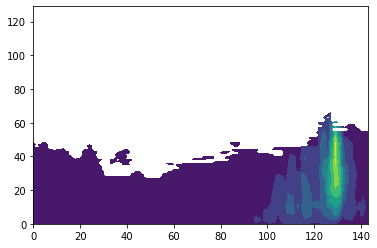

In [50]:
plt.contourf(obs_wvar[:, :].T)

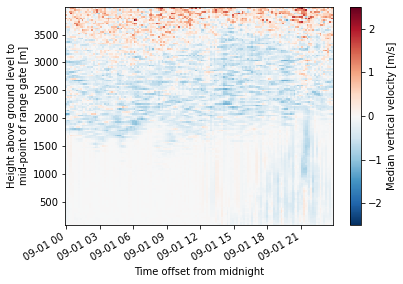

In [55]:
obs_ds['w'].T.plot()

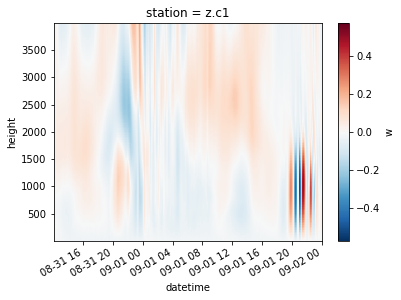

In [5]:
wrf_meso_ds['w'].T.plot()

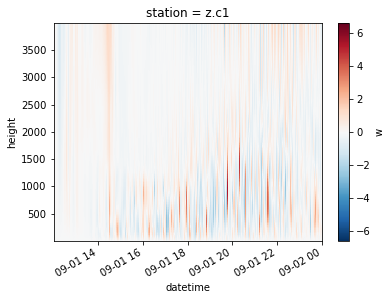

In [7]:
wrf_les200_ds['w'].T.plot()

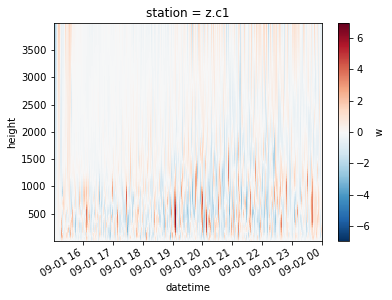

In [6]:
wrf_les40_ds['w'].T.plot()

In [20]:
model4D_calcQOIs(ds, mean_dim='datetime', data_type='ts', lowess_delta=30*60*dt)

Calculating means... this may take a while.
calculating static means
calculating variances / covariances...


<xarray.Dataset>
Dimensions:    (datetime: 12960, height: 167, station: 1)
Coordinates:
  * datetime   (datetime) datetime64[ns] 2018-08-31T12:00:10 ... 2018-09-02
  * height     (height) float64 10.0 20.0 30.0 ... 3.915e+03 3.945e+03 3.975e+03
  * station    (station) <U4 'z.c1'
Data variables:
    theta      (datetime, height, station) float64 299.8 299.8 ... 320.0 320.1
    pr         (datetime, height, station) float64 9.765e+04 ... 6.179e+04
    w          (datetime, height, station) float64 -0.01035 ... -0.02343
    u          (datetime, height, station) float64 -0.0006552 0.013 ... 0.447
    qv         (datetime, height, station) float64 0.01224 0.0122 ... 0.002399
    v          (datetime, height, station) float64 5.859 6.05 ... 6.145 6.116
    i          (station) int64 122
    j          (station) int64 126
    lat        (station) float64 36.62
    lon        (station) float64 -97.49
    zsurface   (station) float64 306.8
    t2         (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    q2         (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    u10        (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    v10        (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    psfc       (datetime, station) float64 -999.0 -999.0 ... 0.5305 0.5305
    lwd        (datetime, station) float64 91.21 91.18 91.15 ... 79.89 79.92
    swd        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 131.8 131.8 131.8
    hfx        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 429.3 429.3 429.3
    lfx        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 52.51 52.51 52.51
    tsk        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 131.8 131.8 131.8
    slttop     (datetime, station) float64 0.0 0.0 0.0 0.0 ... 429.4 429.4 429.4
    rainc      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 131.2 130.6 130.0
    rainnc     (datetime, station) float64 0.0 0.0 0.0 0.0 ... 423.9 422.9 421.9
    clw        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 54.33 54.19 54.05
    qfx        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 131.2 130.7 130.1
    ust        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 424.1 423.1 422.1
    uMean      (height, station) float64 -0.2713 -0.3007 ... 0.4847 0.4215
    vMean      (height, station) float64 6.38 7.464 8.102 ... 4.175 4.154 4.134
    wMean      (height, station) float64 -0.01426 -0.0167 ... 0.007254 0.006628
    thetaMean  (height, station) float64 306.4 306.4 306.4 ... 318.2 318.3 318.3
    wspd       (datetime, height, station) float64 5.859 6.05 ... 6.156 6.132
    wdir       (datetime, height, station) float64 180.0 180.1 ... 183.4 184.2
    UMean      (height, station) float64 6.515 7.62 8.268 ... 5.428 5.453 5.481
    UdirMean   (height, station) float64 177.0 177.3 177.5 ... 190.7 189.9 187.9
    uu         (datetime, height, station) float64 0.07324 0.09838 ... 0.0006517
    vv         (datetime, height, station) float64 0.2711 2.001 ... 3.961 3.926
    ww         (datetime, height, station) float64 1.531e-05 ... 0.0009033
    uv         (datetime, height, station) float64 -0.1409 -0.4437 ... 0.05058
    uw         (datetime, height, station) float64 0.001059 ... -0.0007672
    vw         (datetime, height, station) float64 -0.002037 ... -0.05955
    wth        (datetime, height, station) float64 -0.02606 ... -0.05485
    UU         (datetime, height, station) float64 0.4298 2.465 ... 0.4235
    Uw         (datetime, height, station) float64 -0.002565 ... -0.01956
    TKE        (datetime, height, station) float64 0.3278 0.785 ... 0.3257
Attributes:
    MEAN_OPT:  static

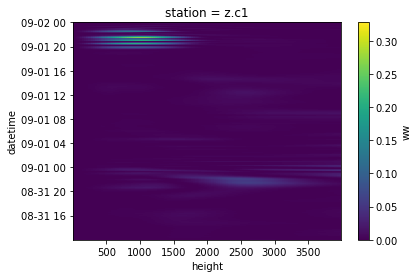

In [22]:
ds['ww'].plot()

In [51]:
ds['ww'].max()

<xarray.DataArray 'ww' ()>
array(0.32786369)

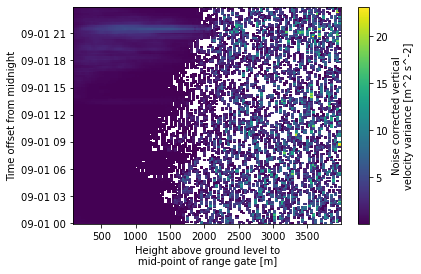

In [48]:
obs_ds['w_variance'].plot()

In [ ]:
def read_tower_to_ds(tower, wrf_start, dt, lev): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=lev, height_var='ph', agl=True)

    # wind speed
    ds['ws'] = np.sqrt(ds['u']**2 + ds['v']**2)
    
    # wind direction
    ds['wd'] = np.mod(180 + np.rad2deg(np.arctan2(ds['u'], ds['v'])), 360) # checked wd, correct

    return ds

def get_wp_height_list(wp_ds):

    wp_height_list = list(wp_ds.height.where((wp_ds.height > toss_wp_data_below_height)).values)
    
    return [x for x in wp_height_list if str(x) != 'nan']

def read_wp_wrf_1day(obs, eval_date, row): 
    
    date_col = data_dir_df[eval_date]

    # start date & end date are the same because only looking at 24 hours of data
    obs_ds = obs.sel(time=slice(eval_date, eval_date))

    # for lidar...
    obs_height_list = get_wp_height_list(obs_ds)
    obs_ds = obs_ds.sel(height=obs_height_list)
    
    # select more model heights than obs
    wrf_height_list = obs_height_list+list(range(10, 101))[0::10]+list(range(350, 3000))[0::100]
    wrf_height_list.sort()
    
    wrf_dir = wrf_runs_dir+date_col[row]+'/'
    
    c1_meso_file_path = wrf_dir+'z_ts/z.'+sim_dict['meso'][0]
    meso_tower = Tower(c1_meso_file_path)

    c1_les200_file_path = wrf_dir+'z_ts/z.'+sim_dict['les200m'][0]
    les200_tower = Tower(c1_les200_file_path)
    
    c1_les40_file_path = wrf_dir+'z_ts/z.'+sim_dict['les40m'][0]
    les40_tower = Tower(c1_les40_file_path)

    # simulation start time
    wrf_start = date_col['wrf_start']

    wrf_meso_ds = read_tower_to_ds(meso_tower, wrf_start, sim_dict['meso'][1], wrf_height_list)
    wrf_les200_ds = read_tower_to_ds(les200_tower, wrf_start, sim_dict['les200m'][1], wrf_height_list)
    wrf_les40_ds = read_tower_to_ds(les40_tower, wrf_start, sim_dict['les40m'][1], wrf_height_list)

    return obs_ds, wrf_meso_ds, wrf_les200_ds, wrf_les40_ds

def plot_wp_ts_profile(eval_date, wrf_run, wrf_ds, wp_ds, wrf_var, wp_var, var_units, freq, wrf_std_ds=None): 
    
    ts_lc_list = ['maroon', 'red', 'orangered', 'darkorange', 'orange']
    lw = 1

    # reverse height list, useful for plotting
    wp_height_list = get_wp_height_list(wp_ds)[:len(ts_lc_list)][::-1]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    for hgt, lc in enumerate(ts_lc_list): 

        # slice of data at each height
        wrf_1height = wrf_ds.sel(height=wp_height_list[hgt])
        wp_1height = wp_ds.sel(height=wp_height_list[hgt])

        ax[0].plot(wrf_1height['datetime'], wrf_1height[wrf_var], 
                 label=str(np.round(wrf_1height['height'].values).astype(int))+' m', 
                 c=lc, linewidth=lw)
        ax[0].plot(wp_1height['time'], wp_1height[wp_var], c=lc, linewidth=lw, linestyle='--')
        
        if wrf_std_ds is not None: 
            
            wrf_std_1height = wrf_std_ds.sel(height=wp_height_list[hgt])
            
            ax[0].fill_between(wrf_std_1height['datetime'], 
                               wrf_1height[wrf_var].squeeze()+wrf_std_1height[wrf_var].squeeze(), 
                               wrf_1height[wrf_var].squeeze()-wrf_std_1height[wrf_var].squeeze(), 
                               alpha=0.1)

    ax[0].tick_params(labelrotation=90)
    # 24 hours of data in plot
    ax[0].set_xlim(parser.parse(eval_date), parser.parse(eval_date)+datetime.timedelta(days=1))
    ax[0].set_xlabel('UTC time')
    ax[0].set_ylabel(var_units)
    ax[0].legend(title=wrf_run)

    wrf_synctime = wrf_ds.sel(datetime=freq, method='nearest')
    wp_synctime = wp_ds.sel(time=freq, method='nearest')

    wrf_hgt_top_i = (wrf_synctime['height'] < profile_hgt_thres).sum().values
    wp_hgt_top_i = (wp_synctime['height'] < profile_hgt_thres).sum().values
    
    profile_lc = list(mcolors.TABLEAU_COLORS)

    for ind, time_i in enumerate(list(range(len(wp_synctime['time']))[0::8])): 

        wrf_time = wrf_synctime['datetime'][time_i].values.astype('datetime64[s]').tolist()

        ax[1].plot(wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], 
                   wrf_synctime['height'][:wrf_hgt_top_i], 
                   c=profile_lc[ind], label='%02d'%wrf_time.hour+':'+'%02d'%wrf_time.minute+'Z')
        ax[1].plot(wp_synctime[wp_var][time_i, :wp_hgt_top_i], 
                   wp_synctime['height'][:wp_hgt_top_i], 
                   linestyle='--', c=profile_lc[ind])
        
        if wrf_std_ds is not None: 
            
            wrf_std_synctime = wrf_std_ds.sel(datetime=freq, method='nearest')
            
            ax[1].fill_betweenx(
                wrf_synctime['height'][:wrf_hgt_top_i],
                wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0]\
                +wrf_std_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], 
                wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0]\
                -wrf_std_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], 
                                
                   color=profile_lc[ind], alpha=0.1)

    ax[1].set_ylabel('Height AGL (m)')
    ax[1].set_xlabel(var_units)
    ax[1].legend(title=wrf_run)
    
    plt.suptitle(wp_var+': '+wrf_run+' (solid) vs '+wp_ds.platform_id+' (dashed): '+eval_date)

#     plt.savefig(plots_dir+'/ts_prof_'+eval_date+'_'+wp_var+'_'+wrf_run+'.pdf')
    
    plt.show()
    plt.close(fig)

def plot_taydiag(obs, eval_date, row): 
    
    obs_ds, wrf_meso_ds, wrf_les200_ds, wrf_les40_ds = read_wp_wrf_1day(obs, eval_date, row)

    wrf_meso_ds_cut = wrf_meso_ds.sel(datetime=slice(
        wrf_meso_ds['datetime'].min().values+sim_dict['meso'][2], obs_ds['time'].max().values))
    wrf_les200_ds_cut = wrf_les200_ds.sel(datetime=slice(
        wrf_les200_ds['datetime'].min().values+sim_dict['les200m'][2], obs_ds['time'].max().values))
    wrf_les40_ds_cut = wrf_les40_ds.sel(datetime=slice(
        wrf_les40_ds['datetime'].min().values+sim_dict['les40m'][2], obs_ds['time'].max().values))

    if obs.platform_id == 'dlprofwind4news': 
        var_dict = dlprofwind_dict
        les_avg_time = '15Min'
    if obs.platform_id == 'dlprofwstats4news': 
        var_dict = dlprofwstats_dict
        les_avg_time = '10Min'
    
    wrf_les200_ds_mean = wrf_les200_ds_cut.resample(datetime=les_avg_time).mean()
    wrf_les200_ds_std = wrf_les200_ds_cut.resample(datetime=les_avg_time).std()
    
    wrf_les40_ds_mean = wrf_les40_ds_cut.resample(datetime=les_avg_time).mean()
    wrf_les40_ds_std = wrf_les40_ds_cut.resample(datetime=les_avg_time).std()

    # get start & end time to trim time series for taylor diagram
    time_start = np.max([wrf_meso_ds_cut['datetime'].min().values, wrf_les200_ds_cut['datetime'].min().values, 
                         wrf_les40_ds_cut['datetime'].min().values, obs_ds['time'].min().values])
    time_end = np.min([wrf_meso_ds_cut['datetime'].max().values, wrf_les200_ds_cut['datetime'].max().values, 
                       wrf_les40_ds_cut['datetime'].max().values, obs_ds['time'].max().values])
    
    # start w/ obs
    time_freq = obs_ds.sel(time=slice(time_start, time_end))['time']
    
    # refer to the most infrequent data series
    # need matching time dimension to calculate correlation, etc. 
    for model in [wrf_meso_ds, wrf_les200_ds, wrf_les40_ds]: 

        model_time_freq = model.sel(datetime=slice(time_start, time_end))['datetime']

        if len(time_freq) > len(model_time_freq): 

            time_freq = model_time_freq

    obs_height_list = get_wp_height_list(obs_ds)

    # taylor diagram for the 1st height
    lev_i = 0

    obs_slice = obs_ds.sel(height=obs_height_list[lev_i], time=time_freq, method='nearest')
    wrf_meso_slice = wrf_meso_ds.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')
    wrf_les200_mean_slice = wrf_les200_ds.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')
    wrf_les40_mean_slice = wrf_les40_ds.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')
    
    for wrf_var, var in var_dict.items():

        print('######################################################################')

        plot_wp_ts_profile(eval_date, row+'-meso', wrf_meso_ds, obs_ds, wrf_var, var[0], var[1], time_freq)
        plot_wp_ts_profile(eval_date, row+'-les200m', wrf_les200_ds_mean, obs_ds, wrf_var, var[0], var[1], 
                           time_freq, wrf_les200_ds_std)
        plot_wp_ts_profile(eval_date, row+'-les40m', wrf_les40_ds_mean, obs_ds, wrf_var, var[0], var[1], 
                           time_freq, wrf_les40_ds_std)

        models = {}
        models['meso'] = wrf_meso_slice[wrf_var]
        models['les200'] = wrf_les200_mean_slice[wrf_var]
        models['les40'] = wrf_les40_mean_slice[wrf_var]

        fig = plt.figure(figsize=(8, 8))
        td = TaylorDiagram(obs_slice[var[0]].std().values, label='lidar', fig=fig,
                           srange=(0, 1.6), extend=False,
                           corrticks=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99],
                           #minorcorrticks=np.arange(0.05,0.9,0.1),
                           #stdevticks=np.arange(0.2,2,0.2),
                           labelsize='x-large')

        for name, series in models.items():
            corr_xy = np.corrcoef(np.squeeze(obs_slice[var[0]]), np.squeeze(series))[0, 1]
            R2 = corr_xy**2
            stdev = series.std().values
            # print(name, stdev, R2)
            td.add_sample(stdev, R2, marker='o', ms=10, ls='', alpha=0.7, label=name)

        td.add_grid()

        contours = td.add_contours(levels=15, colors='0.5')
        plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

        fig.legend(td.samplePoints, [p.get_label() for p in td.samplePoints],
                   numpoints=1, prop=dict(size='medium'), loc='upper right')

        hgt_str = str(np.round(obs_slice['height'].values).astype(int))

        plt.title(row+'\n'+var[0]+' @ '+hgt_str+' m: '+eval_date)

#         plt.savefig(plots_dir+'/taydiag_'+eval_date+'_'+var[0]+'_'+hgt_str+'m_'+row+'.pdf')

        plt.show()
        plt.close('all')

    del(obs_ds, wrf_meso_ds, wrf_les200_ds, wrf_les40_ds)
    
    return obs_slice, wrf_meso_slice, wrf_les200_mean_slice, wrf_les40_mean_slice